# Data Augmentation

In [12]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix, classification_report
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split


In [13]:
# READ IN AUDIO FILES 
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

In [14]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('audio.csv',usecols=['emotion','path'])
audio_df.head()

,emotion,path
0,surprise,/Users/murielkosaka/Desktop/capstone_project/a...
1,surprise,/Users/murielkosaka/Desktop/capstone_project/a...
2,angry,/Users/murielkosaka/Desktop/capstone_project/a...
3,fear,/Users/murielkosaka/Desktop/capstone_project/a...
4,fear,/Users/murielkosaka/Desktop/capstone_project/a...


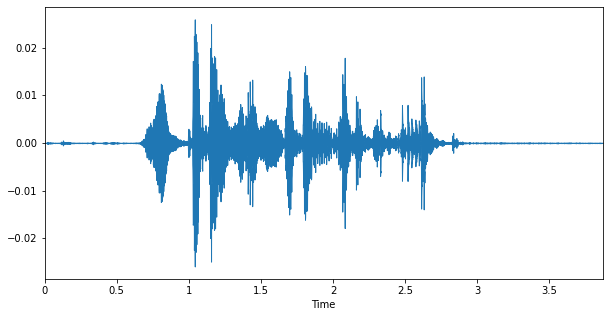

In [15]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)



In [16]:
def noise(x):
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   # more noise reduce the value to 0.5
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

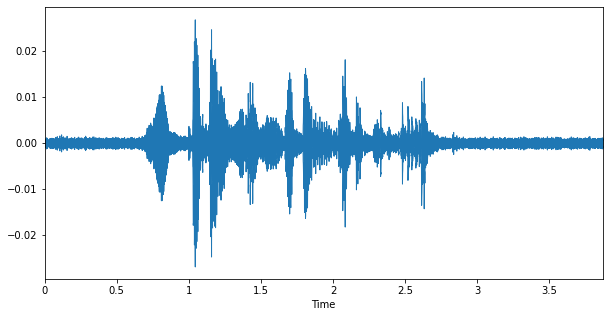

In [17]:
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

In [18]:
def stretch(x, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(x, rate)
    return data

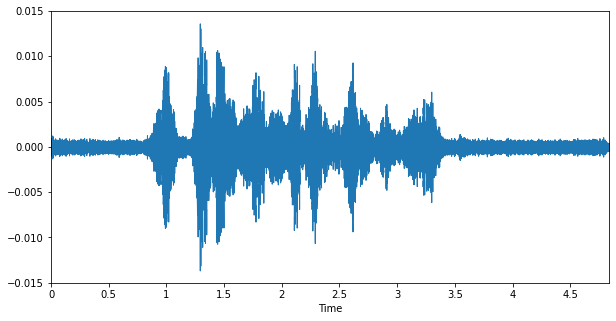

In [19]:
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

In [20]:
def speedNpitch(x):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

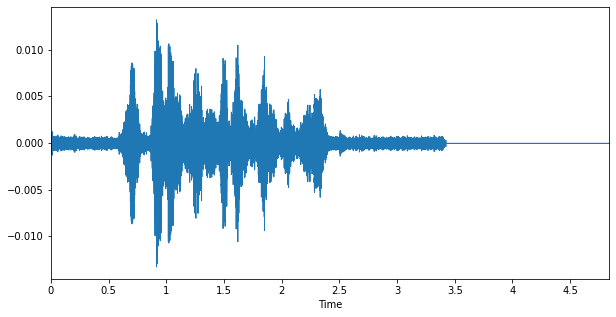

In [21]:
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

In [22]:
df = pd.DataFrame(columns=['log_spec'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
df_stretch=pd.DataFrame(columns=['feature'])
counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   

    # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug]  
    
    # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug]  

    counter += 1
     

print(len(df))
df.head()

1440


,log_spec
0,"[-71.20022, -71.20022, -71.20022, -71.20022, -..."
1,"[-70.46105, -70.46105, -70.46105, -70.46105, -..."
2,"[-64.17679, -64.39374, -64.444954, -64.26804, ..."
3,"[-73.2803, -73.2803, -73.2803, -73.2803, -73.2..."
4,"[-44.965843, -44.467876, -44.512608, -44.93480..."


In [23]:
spec_df = pd.DataFrame(df['log_spec'].values.tolist())
labels = audio_df.emotion
spec = pd.concat([spec_df,labels], axis=1)
spec = spec.rename(index=str, columns={"0": "label"})

In [24]:
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={"0": "label"})

In [25]:
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={"0": "label"})

In [26]:
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={"0": "label"})

In [27]:
combined_df = pd.concat([spec, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,...,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,surprise
1,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,...,-70.461052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
2,-64.176788,-64.393738,-64.444954,-64.268044,-64.303825,-64.468147,-64.468147,-64.468147,-64.468147,-64.468147,...,-64.468147,-64.468147,-64.468147,-64.422607,-64.364937,-64.468147,-64.465858,-64.354759,-64.385941,angry
3,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.255249,-73.086319,-73.234695,-73.280296,-73.280296,...,-73.029083,-73.021973,-73.157417,-73.278503,-73.280296,-73.272202,-73.042091,-72.969475,-73.264915,fear
4,-44.965843,-44.467876,-44.512608,-44.934807,-44.679760,-44.350895,-45.161110,-46.124241,-45.938686,-46.116108,...,-42.546494,-43.290047,-42.981064,-43.380680,-44.499775,-44.815922,-45.377876,-45.876091,-46.404274,fear


## CNN

In [48]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

In [29]:
# TRAIN TEST SPLIT
X_model, X_test, y_model, y_test = train_test_split(combined_df.drop(['emotion'],axis=1)
                                                    , combined_df.emotion
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = combined_df.emotion
                                                   )
# TRAIN TEST SPLIT TO CREATE VALIDATION AND TRAINING SET
X_train, X_validation, y_train, y_validation = train_test_split(X_model
                                                    , y_model
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = y_model
                                                   )



In [30]:
y_validation.value_counts()

sad         144
disgust     144
calm        144
fear        144
angry       144
happy       144
surprise    144
neutral      72
Name: emotion, dtype: int64

In [31]:
y_test.value_counts()

angry       192
surprise    192
sad         192
disgust     192
calm        192
fear        192
happy       192
neutral      96
Name: emotion, dtype: int64

In [32]:
y_train.value_counts()

surprise    432
disgust     432
angry       432
sad         432
calm        432
fear        432
happy       432
neutral     216
Name: emotion, dtype: int64

In [20]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_validation = (X_validation - mean) / std



In [21]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation=np.array(X_validation)
y_validation=np.array(y_validation)

In [22]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
y_validation = to_categorical(lb.fit_transform(y_validation))


print(y_validation[0:10])

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [23]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [24]:
print(y_validation[0:10])

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [55]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_validation = X_validation[:,:,np.newaxis]

X_train.shape

(4608, 259, 1, 1)

In [50]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.optimizers import SGD
from keras.constraints import max_norm
from keras.regularizers import l2


# acc-51,test acc-48
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
# model.add(Conv1D(256, kernel_size=(4), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 128)            0         
__________

In [51]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

cb_aug = ModelCheckpoint(filepath='best_model_aug.h5', monitor='val_accuracy', save_best_only=True)
# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=32, epochs=50, validation_data=(X_validation, y_validation),callbacks=[cb_aug])

ValueError: Error when checking input: expected conv1d_3_input to have 3 dimensions, but got array with shape (1080, 259)

In [28]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1440/1440 [==============================] - 1s 1ms/step
Loss of the model is -  1.1435194359885321
1440/1440 [==============================] - 1s 892us/step
Accuracy of the model is -  59.93055555555556 %


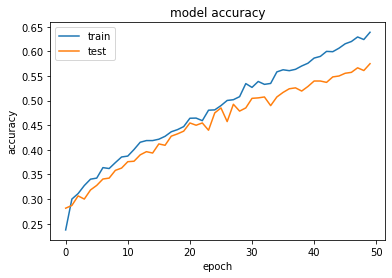

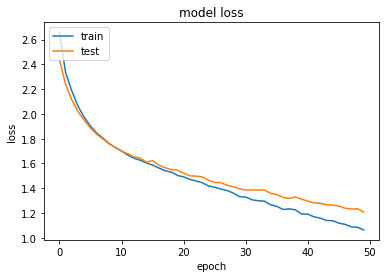

In [29]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
actual=y_test.argmax(axis=1)

In [31]:
lb.classes_

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype=object)

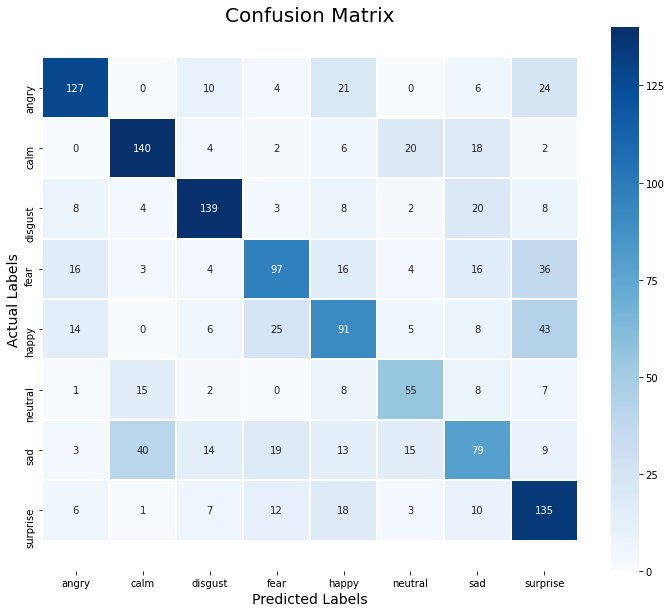

In [32]:
import seaborn as sns

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
# predictions 
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,surprise,surprise
141,happy,fear
142,angry,angry
143,surprise,surprise
144,happy,happy
145,surprise,surprise
146,happy,surprise
147,surprise,surprise
148,neutral,calm
149,surprise,surprise


In [34]:
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,...,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,surprise
1,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,...,-70.461052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
2,-64.176788,-64.393738,-64.444954,-64.268044,-64.303825,-64.468147,-64.468147,-64.468147,-64.468147,-64.468147,...,-64.468147,-64.468147,-64.468147,-64.422607,-64.364937,-64.468147,-64.465858,-64.354759,-64.385941,angry
3,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.255249,-73.086319,-73.234695,-73.280296,-73.280296,...,-73.029083,-73.021973,-73.157417,-73.278503,-73.280296,-73.272202,-73.042091,-72.969475,-73.264915,fear
4,-44.965843,-44.467876,-44.512608,-44.934807,-44.679760,-44.350895,-45.161110,-46.124241,-45.938686,-46.116108,...,-42.546494,-43.290047,-42.981064,-43.380680,-44.499775,-44.815922,-45.377876,-45.876091,-46.404274,fear


In [73]:
from sklearn.model_selection import StratifiedShuffleSplit

#  Stratified Shuffle Split

X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
xxx = StratifiedShuffleSplit(3, test_size=0.25, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

In [74]:
y_train.value_counts()

surprise    576
disgust     576
angry       576
sad         576
calm        576
fear        576
happy       576
neutral     288
Name: emotion, dtype: int64

In [75]:
y_test.value_counts()

angry       192
surprise    192
sad         192
disgust     192
calm        192
fear        192
happy       192
neutral      96
Name: emotion, dtype: int64

In [76]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [77]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [78]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


print(y_test[0:10])

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [79]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [80]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_test.shape

(1440, 259, 1)

In [81]:
# acc-51,test acc-48
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
# model.add(Conv1D(256, kernel_size=(4), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 128)            0         
__________

In [92]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

file="weights_aug.hdf5"
cb = ModelCheckpoint(file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callback = [cb]# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=32, epochs=100, validation_data=(X_test, y_test),callbacks=[cb])

Train on 4320 samples, validate on 1440 samples
Epoch 1/100
4320/4320 [==============================] - 16s 4ms/step - loss: 0.7121 - acc: 0.7701 - val_loss: 0.7779 - val_acc: 0.7771
Epoch 2/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.5782 - acc: 0.8190 - val_loss: 0.7555 - val_acc: 0.7951
Epoch 3/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.5329 - acc: 0.8387 - val_loss: 0.7239 - val_acc: 0.7937
Epoch 4/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.5236 - acc: 0.8417 - val_loss: 0.7367 - val_acc: 0.8028
Epoch 5/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.5038 - acc: 0.8475 - val_loss: 0.7241 - val_acc: 0.8083
Epoch 6/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.4882 - acc: 0.8558 - val_loss: 0.7325 - val_acc: 0.8111
Epoch 7/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.4841 - acc: 0.8569 - val_loss: 0.7444 - val_acc: 0.8076


4320/4320 [==============================] - 12s 3ms/step - loss: 0.2680 - acc: 0.9308 - val_loss: 0.6254 - val_acc: 0.8694
Epoch 61/100
4320/4320 [==============================] - 11s 3ms/step - loss: 0.2751 - acc: 0.9255 - val_loss: 0.5847 - val_acc: 0.8833
Epoch 62/100
4320/4320 [==============================] - 11s 3ms/step - loss: 0.2750 - acc: 0.9308 - val_loss: 0.5928 - val_acc: 0.8743
Epoch 63/100
4320/4320 [==============================] - 11s 3ms/step - loss: 0.2584 - acc: 0.9350 - val_loss: 0.6043 - val_acc: 0.8819
Epoch 64/100
4320/4320 [==============================] - 11s 3ms/step - loss: 0.2762 - acc: 0.9287 - val_loss: 0.6024 - val_acc: 0.8792
Epoch 65/100
4320/4320 [==============================] - 11s 3ms/step - loss: 0.2787 - acc: 0.9197 - val_loss: 0.5876 - val_acc: 0.8778
Epoch 66/100
4320/4320 [==============================] - 12s 3ms/step - loss: 0.2576 - acc: 0.9356 - val_loss: 0.5832 - val_acc: 0.8792
Epoch 67/100
4320/4320 [==============================

In [93]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1440/1440 [==============================] - 1s 841us/step
Loss of the model is -  0.5784851607349184
1440/1440 [==============================] - 1s 782us/step
Accuracy of the model is -  88.05555555555556 %


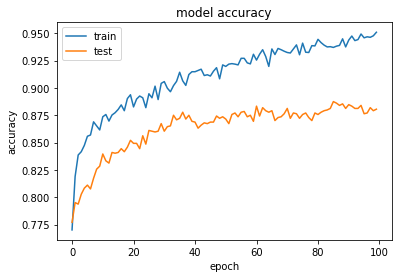

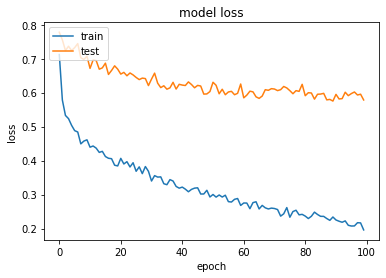

In [94]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
actual=y_test.argmax(axis=1)

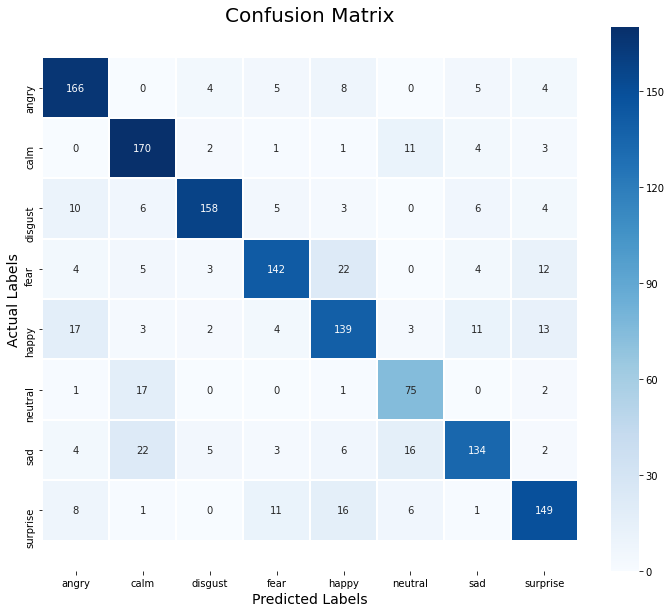

In [89]:
import seaborn as sns

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [66]:
# predictions 
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,happy,happy
141,fear,surprise
142,disgust,disgust
143,calm,calm
144,neutral,neutral
145,happy,surprise
146,calm,calm
147,fear,fear
148,calm,calm
149,calm,neutral
